In [ ]:
from sklearn.feature_extraction import image
from matplotlib import pyplot as plt
import numpy as np
from google.colab import drive
from tensorflow import keras
import cv2
import matplotlib.patches as plt_patches

In [ ]:
# mount the drive 

drive.mount('/content/drive')

In [ ]:
resmodel = keras.models.load_model('drive/My Drive/BreastCancer/Model Weights/ResNetCompleteMammogram.h5')
roimodel = keras.models.load_model('drive/My Drive/BreastCancer/Model Weights/ROICNN_final_weights.h5')       # models have been imported 

In [ ]:
def find_corr(img_arr,patches,max_index):
  arr_h = img_arr
  arr_n = patches[max_index].squeeze()

  y_h, x_h = arr_h.shape[:2]
  y_n, x_n = arr_n.shape[:2]

  xstop = x_h - x_n + 1
  ystop = y_h - y_n + 1

  matches = []
  for xmin in range(0, xstop):
      for ymin in range(0, ystop):
          xmax = xmin + x_n
          ymax = ymin + y_n

          arr_s = arr_h[ymin:ymax, xmin:xmax]     # Extract subimage
          arr_t = (arr_s == arr_n) # Create test matrix

          if arr_t.all():                         # Only consider exact matches
              matches.append((xmin,ymin))
  return matches

In [ ]:
from google.colab import files
files.upload()

Saving image_1.png to image_1.png


{'image_1.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xa5\x00\x00\x00\xa0\x08\x06\x00\x00\x00m\xe6\xaci\x00\x00 \x00IDATx\x9c\xe4\xbd\xf7w[\x87\x95\xef\xfb\xfe\x8f\xb7\xee\x8d\xc4\xde\xbbH\xaaWJ\xa2H\x91\xa2(\xf6N\xf4\x0e\x02\x04A\xa2\x03\xec\xbd\x17\xb1\x8a\xea\xbd\xf7^-\xd9V\xb1-[.qM\x8f\x9d\xe2I\xe2\xc4\x8e-\x7f\xde\x0f\x078\x96lg&w\xc6s\x9dY\xcf^{I\x00y\x80\x03\x9d\xef\xd9\xe5\xbb\xbf{\xe3\xff\xb9w\xf7.!?Y@\xe8\x82 B~\xb2\xf0;\x16\xb4\xe0y\x0b^\x18DP\xd07\xb6p\xc1\x02\x82\x16.$h\xe1B\x82\x83\x82\t\n\n"x\xa1\xdf\x16|\xf7\xf8\xff\xac}\xdf\xb9\xfd{\xe7\x19\xb4`!\x0b\x17,d\xe1\xc2\xe7-\xe8\x19\x0b^\xf0]\xfb?>\xaf\xa0`B\x83\x83\t\r\x0e!,$\x94\x88\xb0p"\xc3#\x88\x08\x0b\'<4\x8c\xf0\xd00\xa2""\x88\x8a\x88$\xd2\xff3\xc1"\x89\x8a\x8c!&:\x8e\x98\xe88\xa2"c\x88\x08\x8f"2"\x9a\xb8\xd8\x04\xe2\xe3\x12\x89\x8bM :*\x96\x98\xe88bc\xe2ILH&))\x85\x84\xf8$\xe2b\x13H\x88O"!>\x89\xf8\xf8D\xe2\xe3\xbe\xb18\xff\xb1\xb11\xf1\xa2%$$\xb1(%\x8deKW\xb0j\xe5\x1aV\xacXEz\xda\x12\xe2\xe2\x12\x08\x0f\

In [ ]:
mammogram = cv2.imread('image_1.png')
print(mammogram.shape)

(160, 165, 3)


[0. 1.]


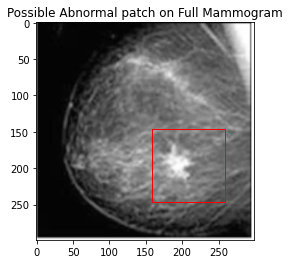

In [ ]:
# Here we will test the automatic annotation part 

def find_lesions(mammogram):
  img_shape = mammogram.shape
  if(img_shape[-1]>3):
    print('This image will not be processed, please enter either RGB or grayscale Image')
    return 
  else:
    # First convert it to a RGB Image 
    mammogram_gray = cv2.cvtColor(mammogram, cv2.COLOR_BGRA2GRAY)         # Grayscale Mammogram
    mammogram_gray_temp = mammogram_gray.copy() 
    mammogram_gray = (mammogram_gray-np.mean(mammogram_gray))/np.std(mammogram_gray)
    
    # Do mean subtraction and standardization first 
    

    mammogram_gray = cv2.resize(mammogram_gray,(299,299))               # Resize this is required for ResNet
    mammogram_gray = np.resize(mammogram_gray,(1,mammogram_gray.shape[0],mammogram_gray.shape[1],1))
    
    mammogram = np.repeat(mammogram_gray,3,axis=3)             # For Resnet 
    prediction = resmodel.predict(mammogram)[0]
    positive_possibility = prediction[1]
    print(prediction)
    if(positive_possibility>=0.35):                          # Cancer Possibly 
      mammogram = mammogram_gray_temp                        # Original GrayLevel MAmmogram 
      mammogram = cv2.resize(mammogram,(299,299))
      patches = image.extract_patches_2d(mammogram, (100, 100),max_patches=200)
      patches_temp = patches
      for i,p in enumerate(patches):
        if(i==0):
          q = (p-np.mean(p))/np.std(p)
          patches_new = np.array([q])
        else:
          q = (p-np.mean(p))/np.std(p)
          patches_new = np.vstack((patches_new,[q]))

      patches = patches_new
      patches = np.resize(patches_new,(patches.shape[0],patches.shape[1],patches.shape[2],1))
      prediction = roimodel.predict(patches)
      maximum = -1000000
      tutu = 10000000000
      for i,p in enumerate(prediction):
        if(p[1]>p[0]):
            if(p[1]>maximum):
                max_index = i
                maximum = p[1]
                tutu = p
      
      x = find_corr(mammogram,patches_temp,max_index)[0][0]
      y = find_corr(mammogram,patches_temp,max_index)[0][1]
      # print(max_index)
      fig,ax = plt.subplots(1)
      ax.imshow(mammogram,cmap='gray')

      # Create a Rectangle patch
      rect = plt_patches.Rectangle((x,y),100,100,linewidth=1,edgecolor='r',facecolor='none')
      ax.add_patch(rect)
      plt.title('Possible Abnormal patch on Full Mammogram')
      plt.show()
    else:
      print('No Cancer in the submitted Mammogram')

  return 

find_lesions(mammogram)


Mounted at /content/drive


In [ ]:

roimodel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 98, 98, 64)        640       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 9, 9, 64)         

In [ ]:
resmodel.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________